# Results for paper: TITLE

In [2]:
from openfermion import get_sparse_operator
from scipy.sparse.linalg import eigsh
from pathlib import Path
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry

def ground(hamiltonian):
    sparse_ham = get_sparse_operator(hamiltonian)
    eigenvalue, _ = eigsh(sparse_ham, k=1, which='SA')
    return eigenvalue[0]

def find_and_save(mol_name):
    if Path(f'./molecular_structures/{mol_name}.xyz').exists():
        print(f'xyz file for {mol_name} already exists.\n')
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    print('Molecule geometry:')
    print(geo_dict)
    save_ordered_xyz_file(mol_name, geo_dict, [0])
    print(f'xyz file for {mol_name} created.\n')

def print_results(result, active):
    
    print(f"Qubits\t\t{result[active]['mu']['n_qubits']}/{result[active]['huz']['n_qubits']}/{result['full']['n_qubits']}")
    print(f"Terms\t\t{result[active]['mu']['terms']}/{result[active]['huz']['terms']}/{result['full']['terms']}")
    print(f'DFT:\t\t{result["e_dft"]}')
    #print(f"CCSD Emb:\t{result['mu']['e_ccsd']}/{result['huz']['e_ccsd']}")
    print(f"Mu Emb:\t\t{result[active]['mu']['ground']}")
    print(f"Huz Emb:\t{result[active]['huz']['ground']}")
    print(f"Diagonalized:\t{result['full']['ground']}")
    print("\n")

def save_data(result, mol_name, localisation, force: bool):
    savefile = f'../data/{mol_name}_{localisation}.json'

    with open(savefile, 'w') as f:
        json.dump(result, f, indent=4)
        print(f'{savefile} created.')

/home/mwilliams/anaconda3/envs/nbed/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [14]:
# acetonitrile
# N-methylmethanamine
# acetaldehyde
# formamide
# ethanamine
# ethanol
# methoxymethane
# fluoroethane
# acetone
# Isopropyl alcohol 

find_and_save('Isopropyl alcohol')

Molecule geometry:
{0: ('O', (-0.0004, 1.3572, -0.1242)), 1: ('C', (0, 0.0177, 0.3601)), 2: ('C', (-1.2599, -0.6878, -0.1179)), 3: ('C', (1.2603, -0.6871, -0.1179)), 4: ('H', (-0.0001, 0.0646, 1.454)), 5: ('H', (-1.3079, -1.7139, 0.259)), 6: ('H', (-2.1507, -0.1484, 0.2213)), 7: ('H', (-1.3061, -0.7138, -1.2122)), 8: ('H', (1.3089, -1.7132, 0.259)), 9: ('H', (2.1508, -0.1471, 0.2213)), 10: ('H', (1.3066, -0.7131, -1.2122)), 11: ('H', (-0.0006, 1.3242, -1.0961))}
xyz file for Isopropyl alcohol created.



In [67]:
from nbed.mol_plot import Draw_molecule

file = 'molecular_structures/fluoroethane.xyz'

with open(file, 'r') as f:
    xyz = f.read()

print(xyz)

viewer = Draw_molecule(xyz, width=400, height=400, style='sphere')
viewer.show()

8
 
F	1.1298	0.3032	0
C	0.0745	-0.5534	0
C	-1.2043	0.2502	0
H	0.1472	-1.1828	-0.891
H	0.1471	-1.1828	0.891
H	-2.0791	-0.4057	-0.0001
H	-1.2472	0.8979	0.881
H	-1.2471	0.898	-0.8809



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [32]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json
from pyscf import cc

localisation = ['spade','mullikan','boys','ipo']

# Need to build paths to xyz files.
max_atoms = 3

def get_results(mol_name, active_atoms, localisation='pipek-mezey', qubits=None, force=True):
    savefile = f'../data/{mol_name}_{localisation}.json'
    if Path(savefile).exists() and not force:
        in_string = input(f"Do you want to overwrite the saved data for {mol_name} [y]/n")
        if in_string != "y":
            print("Not saving.")
            return
    
    print(f"\nGetting results for:\n\t{mol_name}\n\t{active_atoms} atoms\n\t{localisation} localisation\n")
    find_and_save(mol_name)
    geometry = f'./molecular_structures/{mol_name}.xyz'

    config = {}
    # We pass these to the driver.
    config['localization']=localisation
    config['basis']='sto-3g'
    config['xc_functional']='b3lyp'
    config['convergence']=1e-6
    config['savefile']=None
    config['charge']=0
    config['mu_level_shift']=1e6
    config['run_ccsd_emb']=False
    config['run_fci_emb']=False
    config['max_ram_memory']=8_000
    config['pyscf_print_level']=1
    
    result = {}
    result.update(config)
    transform='jordan_wigner'

    for active in active_atoms:
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(geometry=geometry, n_active_atoms=active, projector='both', **config)
        print("Driver finished.")
        if active == 1:
            result['full'] = {}
            result['e_dft'] = driver._global_rks.e_tot
            full_builder = HamiltonianBuilder(driver._global_hf, constant_e_shift=driver._global_hf.energy_nuc(), transform=transform)
            full_ham = full_builder.build(qubits, taper=False)
            result['full']['qham'] = HamiltonianConverter(full_ham)._intermediate
            result['full']['terms'] = len(full_ham.terms)
            result['full']['n_qubits'] = count_qubits(full_ham)
            result['full']['classical_energy'] = 0
            result['full']['ground'] = None
            print('Full system Hamiltonian built.')


        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(driver._mu['scf'], driver._mu['classical_energy'], transform=transform)
        qham = mu_builder.build(qubits, taper=False)
        result[active]['mu'] = {}
        result[active]['mu']['qham'] = HamiltonianConverter(qham)._intermediate
        result[active]['mu']['terms'] = len(qham.terms)
        result[active]['mu']['n_qubits'] = count_qubits(qham)
        result[active]['mu']['classical_energy'] = driver._mu['classical_energy']
        result[active]['mu']['ground'] = None
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(driver._huzinaga['scf'], driver._huzinaga['classical_energy'], transform=transform)
        qham = huz_builder.build(qubits, taper=False)
        result[active]['huz'] = {}
        result[active]['huz']['qham'] = HamiltonianConverter(qham)._intermediate
        result[active]['huz']['terms'] = len(qham.terms)
        result[active]['huz']['n_qubits'] = count_qubits(qham)
        result[active]['huz']['classical_energy'] = driver._huzinaga['classical_energy']
        result[active]['huz']['ground'] = None
        print("Huzinaga finished.")


# untapered_mu = mu_builder.build(taper=False)
# untapered_huz = huz_builder.build(taper=False)
# untapered_full = full_builder.build(taper=False)
# print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
# print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
# print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")
        
        print_results(result, active)
            
    result['mol_name']=mol_name
    result['transform']=transform
    result['qubit_limit'] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result


/home/mwilliams/anaconda3/envs/nbed/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [42]:
get_results("cyclopentane", 5, force=False, localisation='spade')


Getting results for:
	cyclopentane
	5 atoms
	spade localisation

Molecule geometry:
{0: ('C', (-1.0551, -0.658, 0.2446)), 1: ('C', (-0.9716, 0.7805, -0.2349)), 2: ('C', (0.2952, -1.2327, -0.1536)), 3: ('C', (0.4469, 1.1915, 0.1309)), 4: ('C', (1.2846, -0.0814, 0.013)), 5: ('H', (-1.1742, -0.6896, 1.334)), 6: ('H', (-1.8887, -1.202, -0.2082)), 7: ('H', (-1.1092, 0.8265, -1.3217)), 8: ('H', (-1.724, 1.422, 0.2327)), 9: ('H', (0.5683, -2.1041, 0.4489)), 10: ('H', (0.2713, -1.5481, -1.2036)), 11: ('H', (0.821, 1.9934, -0.5127)), 12: ('H', (0.4759, 1.556, 1.1648)), 13: ('H', (1.8979, -0.2164, 0.9106)), 14: ('H', (1.9655, -0.0323, -0.8435))}
xyz file for cyclopentane created.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		32/32/70
Terms		94833/94097/2210438
DFT:		-194.07974854469768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
Driver finished.
Mu finished.
Huzinaga finishe

Driver finished.
Mu finished.
Huzinaga finished.
Qubits		56/56/70
Terms		901889/889329/2210438
DFT:		-194.07974854469768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 4 active atoms.


Driver finished.
Mu finished.
Huzinaga finished.
Qubits		64/64/70
Terms		1542229/1523777/2210438
DFT:		-194.07974854469768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 5 active atoms.
Driver finished.
Mu finished.
Huzinaga finished.
Qubits		50/50/70
Terms		571764/571760/2210438
DFT:		-194.07974854469768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/cyclopentane_spade.json created.




{'localization': 'spade',
 'basis': 'sto-3g',
 'xc_functional': 'b3lyp',
 'convergence': 1e-06,
 'savefile': None,
 'charge': 0,
 'mu_level_shift': 1000000.0,
 'run_ccsd_emb': False,
 'run_fci_emb': False,
 'max_ram_memory': 8000,
 'pyscf_print_level': 1,
 'full': {'qham': {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': -115.21248844147364,
   'ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.8062489857821715,
   'IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.8062489857821715,
   'IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.806154557974185,
   'IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.8061545579741844,
   'IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.804565718820287,
   'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.804565718820286,
   'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [34]:
# acetonitrile
# N-methylmethanamine
# acetaldehyde
# formamide
# ethanamine
# ethanol
# methoxymethane
# fluoroethane
# acetone
# isopropyl_alcohol 

mols = []
for mol in mols:
    get_results(mol, [1], force=False, localisation='ibo')

mols = ['N-methylmethanamine', 'acetonitrile', 'ethanol', 'fluoroethane', 'isopropyl_alcohol']
for mol in mols:
    get_results(mol, [2], force=False, localisation='ibo')

for mol in ['ethanamine', 'formamide', 'acetaldehyde']:
    get_results(mol, [3], force=False, localisation='ibo')


Getting results for:
	ammonia
	1 atoms
	ibo localisation

xyz file for ammonia already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 2.54e-12
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/16
Terms		864/864/5389
DFT:		-55.75029515544364
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/ammonia_ibo.json created.



Getting results for:
	methane
	1 atoms
	ibo localisation

xyz file for methane already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 4.85e-10
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/18
Terms		852/852/8776
DFT:		-40.00278916556489
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/methane_ibo.json created.



Getting results for:
	nitrogen
	1 atoms
	ibo localisation

xyz file for nitrogen already exists.

Starting driver with 1 active atoms.
 Itera

Driver finished.
Mu finished.
Huzinaga finished.
Qubits		32/32/52
Terms		90865/87229/634239
DFT:		-186.74115370337188
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/azomethane_ibo.json created.



Getting results for:
	carbon dioxide
	2 atoms
	ibo localisation

Molecule geometry:
{0: ('O', (-1.197, 0, 0)), 1: ('O', (1.197, 0, 0)), 2: ('C', (0, 0, 0))}
xyz file for carbon dioxide created.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.46e-09
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/30
Terms		276/876/16170
DFT:		-185.89763693889233
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.46e-09
Driver finished.
Mu finished.
Huzinaga finished.
Qubits		12/12/30
Terms		327/919/16170
DFT:		-185.89763693889233
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/carbon dioxide_ibo.json c

Driver finished.
Mu finished.
Huzinaga finished.
Qubits		20/20/24
Terms		6895/6987/8865
DFT:		-109.08876701453298
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/diazene_ibo.json created.



Getting results for:
	ethane
	2 atoms
	ibo localisation

xyz file for ethane already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 4.07e-09
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		16/16/32
Terms		5789/5789/46105
DFT:		-78.81931936127972
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 4.07e-09
Driver finished.
Mu finished.
Huzinaga finished.
Qubits		20/20/32
Terms		7175/7039/46105
DFT:		-78.81931936127972
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


../data/ethane_ibo.json created.



Getting results for:
	ethene
	2 atoms
	ibo localisation

xyz file for ethene already exists.

Starting 

In [71]:
with open('../data/cyclopentane_spade.json', 'r') as f:
    cyclopropane = json.load(f)

In [75]:
whole_dft = cyclopropane['e_dft']
active_atoms = range(1,6)
cp_qubits = [cyclopropane[str(i)]['mu']['n_qubits'] for i in active_atoms]
cp_terms = [cyclopropane[str(i)]['mu']['terms'] for i in active_atoms]

In [81]:
full_terms = cyclopropane['full']['terms']
full_n_qubits = cyclopropane['full']['n_qubits']

/home/mwilliams/anaconda3/envs/nbed/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


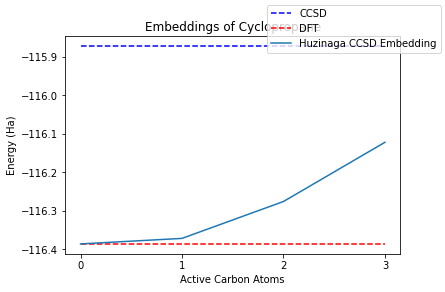

In [76]:
fig, ax = plt.subplots()
# ax.hlines(whole_ccsd, min(active_atoms), max(active_atoms), colors='blue', linestyle='dashed', label='CCSD')
ax.hlines(whole_dft, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label='DFT')
ax.plot(active_atoms, energies, label='Huzinaga CCSD Embedding')
ax.set_xlabel('Active Carbon Atoms')
ax.set_ylabel('Energy (Ha)')
ax.set_xticks(active_atoms)
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

/tmp/ipykernel_535959/712870501.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


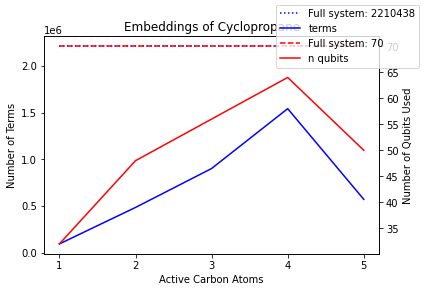

In [82]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel('Number of Qubits Used')
ax2.hlines(full_n_qubits, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label=f'Full system: {full_n_qubits}')
ax2.plot(active_atoms, cp_qubits, linestyle='solid', color='red', label='n qubits')
ax.hlines(full_terms, min(active_atoms), max(active_atoms), colors='blue', linestyle='dotted', label=f'Full system: {full_terms}')
ax.plot(active_atoms, cp_terms, linestyle='solid', color='blue', label='terms')
ax.set_xlabel('Active Carbon Atoms')
ax.set_xticks(active_atoms)
ax.set_ylabel('Number of Terms')
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

In [2]:
# Extract data from the results json files

from pathlib import Path
import json

data = {}
for file in Path("../results/").iterdir():
    if "spade" in file.name:
        continue
    
    with open(file, 'r') as f:
        file_data = json.load(f)

    mol_name = file_data['mol_name']
    data[mol_name] = file_data
    data[mol_name]['full'].pop('qham')

    for i in range(5):
        n_data = data[mol_name].get(str(i), False)
        if n_data:
            n_data['huz'].pop('qham')
            n_data['mu'].pop('qham')

# Filters out anything too big to get the embedded ground state
data = {key: data[key] for key in sorted(data) if data[key]['1']['mu']['ground']}

In [3]:
import pandas as pd
df = pd.DataFrame(data).T

In [4]:
full_vals = pd.DataFrame(df['full'].to_list(), index=df['mol_name'])
one_mu = pd.DataFrame([v['mu'] for v in df['1'].to_list()], index=df['mol_name'])
one_huz = pd.DataFrame([v['huz'] for v in df['1'].to_list()], index=df['mol_name'])

terms  n_qubits  classical_energy        ground
mol_name                                                       
ammonia             0         0     -4.558487e-11  1.711412e-07
carbon dioxide    332         0      1.259082e-11  4.193710e-05
diazene             4         0     -8.101608e-11  2.767264e-03
ethane              0         0      8.284928e-12 -4.014401e-05
ethene              4         0     -6.309619e-12 -5.576762e-05
ethine            740         0      9.144685e-12 -1.157249e-04
methane             0         0      1.811884e-12  4.745338e-08
nitrogen          576         0      1.990088e-10  6.857024e-03
oxygen             -8         0      2.610534e-10  6.997992e-03
water               0         0      2.295799e-10  3.030600e-07

In [65]:
with open('../data/cyclopropane_spade.json', 'r') as f:
    propane = json.load(f)

dict_keys(['qham', 'terms', 'n_qubits', 'classical_energy', 'ground'])

In [10]:
import numpy as np
mol_names = df['mol_name'].to_list()
full_vals = df['full'].to_list()
ccsd_vals = df['e_ccsdt'].to_list()

full_qubits = np.array([v['n_qubits'] for v in full_vals])
full_terms = np.array([v['terms'] for v in full_vals])

act_1 = df['1'].to_list()
mu_vals_1 = [v['mu'] for v in act_1]
huz_vals_1 = [v['huz'] for v in act_1]
mu_qubits_1 = np.array([v['mu']['n_qubits'] for v in act_1])
mu_terms_1 = [v['mu']['terms'] for v in act_1 if type(v) is dict]
huz_qubits_1 = np.array([v['huz']['n_qubits'] for v in act_1])
huz_terms_1 = [v['huz']['terms'] for v in act_1 if type(v) is dict]

act_2 = df['2'].to_list()
mu_vals_2 = [v['mu'] for v in act_2]
huz_vals_2 = [v['huz'] for v in act_2]
mu_qubits_2 = np.array([v['mu']['n_qubits'] for v in act_2])
mu_terms_2 = [v['mu']['terms'] for v in act_2 if type(v) is dict]
huz_qubits_2 = np.array([v['huz']['n_qubits'] for v in act_2])
huz_terms_2 = [v['huz']['terms'] for v in act_2 if type(v) is dict]

In [35]:
energies_full = [v['ground'] if v['ground'] is not None else 0 for v in full_vals]
energies_dft = [v['e_dft'] if v['e_dft'] is not None else 0 for v in data.values()]
energies_mu = [v['ground'] if v['ground'] is not None else 0 for v in mu_vals_1]
energies_huz = [v['ground'] if v['ground'] is not None else 0 for v in huz_vals_1]

energies_full = np.array(energies_full)
energies_dft = np.array(energies_dft)
energies_mu = np.array(energies_mu)
energies_huz = np.array(energies_huz)
energies_ccsd = np.array(ccsd_vals)

dft_diffs = [100*(dft -ccsd)/ccsd if (dft and ccsd) else 0 for dft, ccsd in zip(energies_dft, energies_ccsd)]
mu_diffs = [100*(v -ccsd)/ccsd if (v and ccsd)  else 0 for v, ccsd in zip(energies_mu, energies_ccsd)]
huz_diffs = [100*(v -ccsd)/ccsd if (v and ccsd) else 0 for v, ccsd in zip(energies_huz, energies_ccsd)]



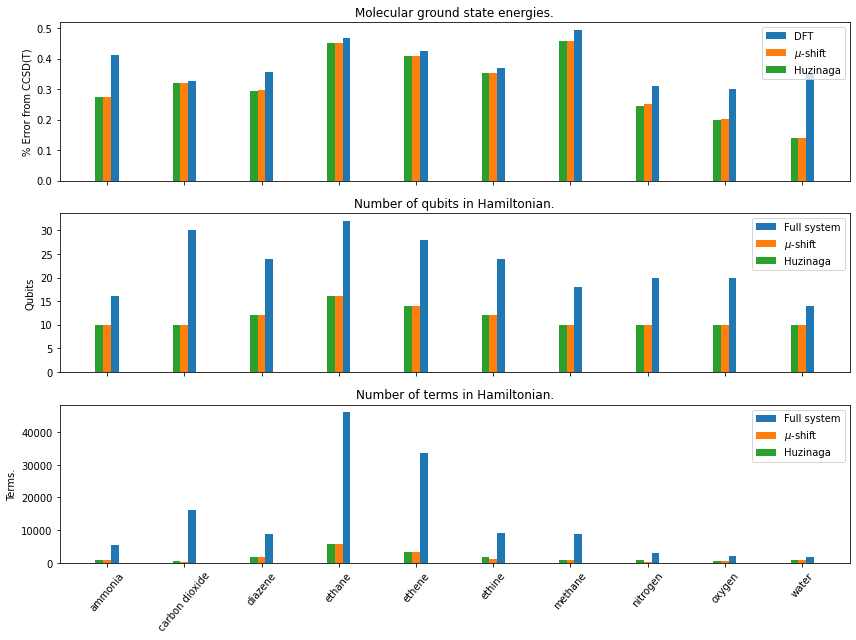

In [38]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(mol_names))  # the label locations
width = 0.1  # the width of the bars

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12,9))
def_es = ax1.bar(x + width, dft_diffs, width, label='DFT')
mu_es = ax1.bar(x, mu_diffs, width, label='$\mu$-shift')
huz_es = ax1.bar(x - width, huz_diffs, width, label='Huzinaga')

full_qubs = ax2.bar(x + width, full_qubits, width, label='Full system')
mu_qubs = ax2.bar(x, mu_qubits_1, width, label='$\mu$-shift')
huz_qubs = ax2.bar(x - width, huz_qubits_1, width, label='Huzinaga')

full_qubs = ax3.bar(x + width, full_terms, width, label='Full system')
mu_qubs = ax3.bar(x, mu_terms_1, width, label='$\mu$-shift')
huz_qubs = ax3.bar(x - width, huz_terms_1, width, label='Huzinaga')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel("% Error from CCSD(T)")
ax1.set_title('Molecular ground state energies.')
ax1.set_xticks(x)
ax1.set_xticklabels(mol_names)
#ax1.tick_params(axis="x", rotation=50)
ax1.legend()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel("Qubits")
ax2.set_title('Number of qubits in Hamiltonian.')
ax2.set_xticks(x)
ax2.set_xticklabels(mol_names)
ax2.tick_params(axis="x", rotation=50)
ax2.legend()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel("Terms.")
ax3.set_title('Number of terms in Hamiltonian.')
ax3.set_xticks(x)
ax3.set_xticklabels(mol_names)
ax3.tick_params(axis="x", rotation=50)
ax3.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for ax in fig.get_axes():
    ax.label_outer()

# autolabel(rects3)
# autolabel(rects2)

fig.tight_layout()
plt.show()

## General Params 
threshold
basis
xc functional


## Small molecules

One for SPADE
One for IBO
Molecule, active atoms(AOs), dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)


Graphs:
Bar graph of molecules energies, hamiltonian size
Cyclic molecule: terms / qubits, energy
bonus: compare molecular orbitals


## H4
One for different numbers of active atoms 1-3
Angle, dft energy, embedding (huz/mu), full_system: fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)

## Water
Bond length, dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)